# Module 7: 特徵選擇 - 1. 過濾法 (Filter Methods)

## 學習目標
- 理解過濾法的基本原理和工作方式。
- 學習並實作如何使用皮爾森相關係數 (Pearson's Correlation) 篩選數值特徵。
- 學習並實作如何使用卡方檢定 (Chi-Squared Test) 篩選類別特徵。
- 學習並實作如何使用 ANOVA F-檢定 (ANOVA F-test) 篩選數值特徵與類別目標的關係。
- 了解過濾法的優缺點及適用場景。

## 導論：如何「獨立」評估特徵的價值？

在您的指南中，我們了解特徵選擇旨在從原始資料中辨識並選取最具預測能力的特徵子集。過濾法作為特徵選擇中最基礎且高效的一類，其獨特之處在於它完全不依賴於任何機器學習模型。它就像一位公正的裁判，僅根據特徵本身的統計特性，如變異數、相關性或統計檢定分數，來獨立評估每個特徵的重要性。

想像一下，如果我們擁有一堆原材料（特徵），過濾法就是透過「重量」、「顏色」等基本屬性來判斷哪些材料更有價值，而無需將它們投入到實際的生產線（模型訓練）中去。這種方法因其計算速度快、不涉及模型訓練而備受青睞，尤其適用於處理大規模資料集或作為特徵選擇的初步步驟。

### 過濾法的優點：
- **計算速度快**：由於無需反覆訓練模型，計算成本非常低，特別適合高維度資料集的快速篩選。
- **模型獨立**：選出的特徵不偏好任何特定模型，因此可以應用於任何機器學習演算法。
- **不易過擬合**：因為不涉及模型訓練，過濾法本身不會產生過擬合的問題。

### 過濾法的缺點：
- **忽略特徵之間的交互作用**：過濾法通常是單變量 (univariate) 的，它一次只評估一個特徵與目標變數的關係，可能會忽略多個特徵組合起來才能發揮的效果。
- **可能選出冗餘特徵**：例如，可能會選出兩個與目標高度相關，但彼此之間也高度相關的特徵，這會增加模型的複雜性而不提供額外資訊。

---

## 1. 載入套件與資料

我們將使用熟悉的鐵達尼號資料集來示範幾種常見的過濾法。這個資料集包含乘客的各類資訊（如年齡、性別、艙等、登船港口等）以及他們是否生還的資訊，是一個非常適合進行特徵選擇教學的經典案例。

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif, chi2
import os

# 設定視覺化風格
sns.set_style('whitegrid')

# 載入資料
DATA_PATH = '../../../../datasets/raw/titanic/Titanic-Dataset.csv'


# 檢查資料是否存在
if not os.path.exists(DATA_PATH):
    print("錯誤：找不到 train.csv 檔案。")
    print(f"請確認您已將資料下載至 '{os.path.abspath(DATA_PATH)}'")
    # 創建一個空的 DataFrame 以避免後續錯誤
    df = pd.DataFrame()
else:
    df = pd.read_csv(DATA_PATH)
    print("資料載入成功！")

# 做一些基本的預處理，以利後續示範
if not df.empty:
    # 填充缺失值
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

    # 將性別轉換為數值
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

    # 將登船港口進行 One-Hot Encoding
    embarked_dummies = pd.get_dummies(df['Embarked'], prefix='Embarked')
    df = pd.concat([df, embarked_dummies], axis=1)

    # 移除不再需要的欄位
    df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)

    print("資料預處理完成！")
    display(df.head())



資料載入成功！
資料預處理完成！


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,False,False,True
1,1,1,1,38.0,1,0,71.2833,True,False,False
2,1,3,1,26.0,0,0,7.9250,False,False,True
3,1,1,1,35.0,1,0,53.1000,False,False,True
4,0,3,0,35.0,0,0,8.0500,False,False,True


## 2. 針對數值特徵的過濾法

### 2.1 皮爾森相關係數 (Pearson's Correlation)

皮爾森相關係數是衡量兩個 **數值變數** 之間 **線性關係** 強弱和方向的統計量。其值介於 -1 到 +1 之間：
- 接近 +1：表示強烈的正向線性關係（一個變數增加，另一個也傾向於增加）。
- 接近 -1：表示強烈的負向線性關係（一個變數增加，另一個傾向於減少）。
- 接近 0：表示兩個變數之間沒有線性關係。

在特徵選擇中，我們通常會尋找與 **目標變數** (`Survived`) 相關性高（絕對值大）的特徵，因為這表示它們對目標變數有較強的線性預測能力。

In [5]:
corr_matrix

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
Survived,1.000000,-0.338481,0.543351,-0.064910,-0.035322,0.081629,0.257307,0.168240,0.003650,-0.149683
Pclass,-0.338481,1.000000,-0.131900,-0.339898,0.083081,0.018443,-0.549500,-0.243292,0.221009,0.074053
Sex,0.543351,-0.131900,1.000000,-0.081163,0.114631,0.245489,0.182333,0.082853,0.074115,-0.119224
Age,-0.064910,-0.339898,-0.081163,1.000000,-0.233296,-0.172482,0.096688,0.030248,-0.031415,-0.006729
SibSp,-0.035322,0.083081,0.114631,-0.233296,1.000000,0.414838,0.159651,-0.059528,-0.026354,0.068734
Parch,0.081629,0.018443,0.245489,-0.172482,0.414838,1.000000,0.216225,-0.011069,-0.081228,0.060814
Fare,0.257307,-0.549500,0.182333,0.096688,0.159651,0.216225,1.000000,0.269335,-0.117216,-0.162184
Embarked_C,0.168240,-0.243292,0.082853,0.030248,-0.059528,-0.011069,0.269335,1.000000,-0.148258,-0.782742
Embarked_Q,0.003650,0.221009,0.074115,-0.031415,-0.026354,-0.081228,-0.117216,-0.148258,1.000000,-0.499421
Embarked_S,-0.149683,0.074053,-0.119224,-0.006729,0.068734,0.060814,-0.162184,-0.782742,-0.499421,1.000000


各特徵與 'Survived' 的相關係數絕對值：
Survived      1.000000
Sex           0.543351
Pclass        0.338481
Fare          0.257307
Embarked_C    0.168240
Embarked_S    0.149683
Parch         0.081629
Age           0.064910
SibSp         0.035322
Embarked_Q    0.003650
Name: Survived, dtype: float64


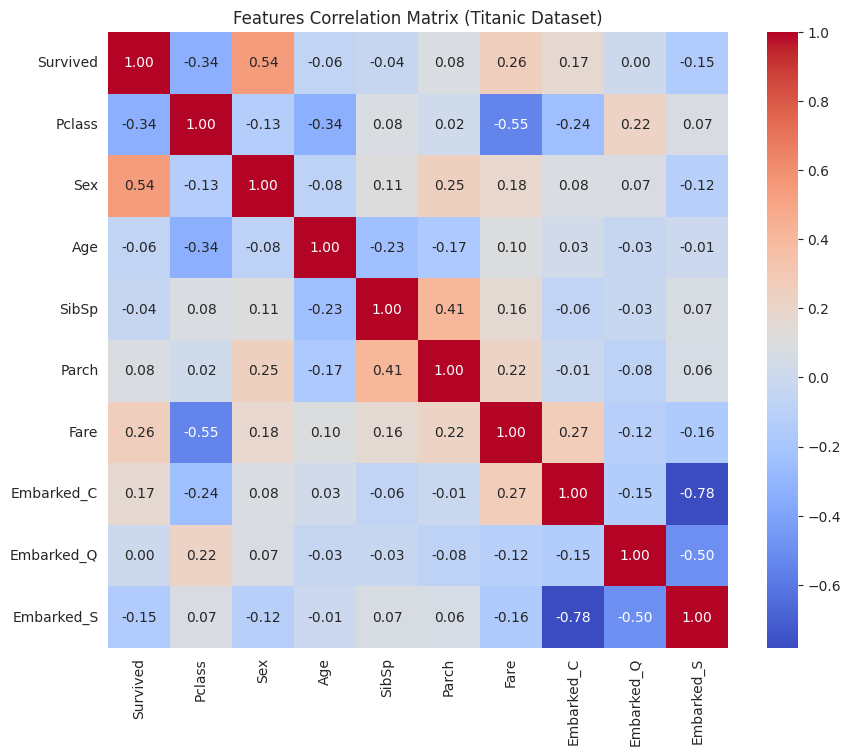

In [3]:
if not df.empty and 'Survived' in df.columns:
    # 計算所有數值特徵與目標變數的相關係數
    corr_matrix = df.corr()
    target_corr = corr_matrix['Survived'].abs().sort_values(ascending=False)

    print("各特徵與 'Survived' 的相關係數絕對值：")
    print(target_corr)

    # 視覺化相關係數熱力圖，更直觀地觀察特徵間的關係
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Features Correlation Matrix (Titanic Dataset)')
    plt.show()



**結果解讀**：

從上方的相關係數列表和熱力圖中，我們可以觀察到 `Sex` (轉換為 0/1 後) 與 `Survived` 的相關性最高 (約 0.54)，這表示性別對生存率有顯著的影響。其次是 `Pclass` (-0.34)，這也印證了頭等艙乘客生還率相對較高的事實。這些都是值得保留的潛在重要特徵。

**應用注意事項**：

- **線性關係限制**：皮爾森相關係數只能捕捉線性關係。如果特徵與目標之間存在非線性關係（例如 U 形關係），此方法可能會低估其重要性。
- **處理共線性**：除了評估單個特徵與目標的關係外，我們也可以利用相關係數來處理 **特徵之間的共線性** 問題。例如，如果發現兩個特徵彼此高度相關，我們可以考慮移除其中一個，以減少模型的冗餘資訊，避免多重共線性問題。

## 3. 針對類別特徵的過濾法

### 3.1 卡方檢定 (Chi-Squared Test)

卡方檢定 (Chi-Squared Test, 簡寫為 `χ²` ) 用於檢驗兩個 **類別變數** 之間是否存在統計上的獨立性。在特徵選擇的背景下，我們的原假設 (Null Hypothesis) 是「特徵與目標變數是獨立的」，即它們之間沒有關聯。

- **P-value 解讀**：如果 P-value 很小 (通常小於顯著水準，如 0.05)，我們就拒絕原假設，認為該特徵與目標變數 **不獨立**，即它們之間 **存在顯著關聯**，因此該特徵是一個有用的特徵。
- **卡方統計量**：卡方統計量越大，表示該特徵與目標變數的關聯性越強。

`sklearn.feature_selection.chi2` 函式要求輸入特徵必須是 **非負值**，這使得它特別適合用於評估經過 One-Hot 編碼後的類別特徵，因為 One-Hot 編碼後的特徵值非 0 即 1。

In [6]:
if not df.empty and 'Survived' in df.columns:
    # 選擇類別型特徵 (這裡我們使用 One-Hot 編碼後的 Embarked 欄位作為示例)
    # 確保這些特徵在 DataFrame 中存在且為數值類型 (One-Hot 編碼會自動處理為數值)
    categorical_features_for_chi2 = [col for col in df.columns if 'Embarked_' in col]
    if categorical_features_for_chi2:
        X_cat = df[categorical_features_for_chi2]
        y = df['Survived']

        # 計算卡方統計量和 P-value
        chi2_scores, p_values = chi2(X_cat, y)

        print("卡方檢定結果：")
        for feature, score, pval in zip(X_cat.columns, chi2_scores, p_values):
            print(f"- 特徵: {feature}, 卡方分數: {score:.2f}, P-value: {pval:.4f}")
    else:
        print("DataFrame 中沒有找到適合卡方檢定的類別特徵 (例如 One-Hot 編碼後的 Embarked)。")



卡方檢定結果：
- 特徵: Embarked_C, 卡方分數: 20.46, P-value: 0.0000
- 特徵: Embarked_Q, 卡方分數: 0.01, P-value: 0.9171
- 特徵: Embarked_S, 卡方分數: 5.49, P-value: 0.0191


**結果解讀**：

從卡方檢定結果中，我們可以看到 `Embarked_S` (從南安普敦登船) 的 P-value 遠大於 0.05，這表示它與生存率的關係在統計上並不顯著。相反，`Embarked_C` (從瑟堡登船) 的 P-value 最小，卡方分數最高，這強烈暗示了從瑟堡登船的乘客與生存率之間存在顯著關聯，因此 `Embarked_C` 是一個重要的特徵。

## 4. 混合資料類型的過濾法

### 4.1 ANOVA F-檢定 (ANOVA F-test)

當我們的輸入是 **數值型特徵**，而目標是 **類別型變數** 時（例如，判斷乘客是否生還 (`Survived`)，基於其年齡 (`Age`) 或票價 (`Fare`)），變異數分析 (ANOVA) 的 F-檢定就派上用場了。

它的基本思想是：如果一個數值特徵對於目標變數的不同類別（例如，生還組與未生還組），其數值的分佈（特別是均值）有顯著差異，那麼這個數值特徵對於區分這些類別就是有幫助的。

`sklearn.feature_selection.f_classif` 函式用於計算每個數值特徵與分類目標之間的 ANOVA F-值和 P-值。`SelectKBest` 則是一個非常實用的工具，它可以根據指定的評分函式 (如 `f_classif` 或 `chi2`)，自動選出分數最高的前 K 個特徵。

In [7]:
if not df.empty and 'Survived' in df.columns:
    # 選擇數值型特徵。這裡我們選擇 Pclass, Sex, Age, SibSp, Parch, Fare
    # 注意：Sex 雖然是 0/1 編碼，但其本質仍是類別，在這裡作為數值處理，ANOVA 依然適用。
    numerical_features_for_anova = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
    
    # 確保所有用於 ANOVA 的數值特徵都存在於 DataFrame 中
    X_num = df[numerical_features_for_anova]
    y = df['Survived']

    # 使用 SelectKBest 搭配 f_classif 來選擇前 3 個最好的特徵
    # k=3 表示我們只選取得分最高的三個特徵
    selector = SelectKBest(score_func=f_classif, k=3)
    selector.fit(X_num, y) # 在數據上擬合選擇器，計算每個特徵的F值和P值
    X_new = selector.transform(X_num) # 轉換數據，只保留選中的特徵

    # 獲取被選中的特徵名稱
    selected_features = X_num.columns[selector.get_support()]

    print("使用 ANOVA F-test 選出的前 3 個特徵是：")
    print(list(selected_features))
    print("\n各特徵的 F-分數 (F-statistic)：")
    for feature, score in zip(X_num.columns, selector.scores_):
        print(f"- {feature}: {score:.2f}")
    print("\n各特徵的 P-value (P-value)：")
    for feature, pval in zip(X_num.columns, selector.pvalues_):
        print(f"- {feature}: {pval:.4f}")



使用 ANOVA F-test 選出的前 3 個特徵是：
['Pclass', 'Sex', 'Fare']

各特徵的 F-分數 (F-statistic)：
- Pclass: 115.03
- Sex: 372.41
- Age: 3.76
- SibSp: 1.11
- Parch: 5.96
- Fare: 63.03

各特徵的 P-value (P-value)：
- Pclass: 0.0000
- Sex: 0.0000
- Age: 0.0528
- SibSp: 0.2922
- Parch: 0.0148
- Fare: 0.0000


**結果解讀**：

`SelectKBest` 根據 `f_classif` 的評分，選出了 `Sex`、`Pclass` 和 `Fare` 作為最重要的三個特徵。這些特徵的 F-分數較高，且 P-value 極小 (通常小於 0.05)，這說明它們與生存率之間存在顯著的統計關聯。這與我們先前用相關係數得到的結論相似，但 ANOVA F-檢定更為嚴謹，因為它不僅考慮了線性關係，更能檢測不同組間均值的差異。

## 5. 總結

過濾法是特徵選擇流程中一個快速且有效的起點，尤其在資料集維度很高時。它提供了一種基於統計獨立性或關聯性來評估特徵價值的方法，並且與後續使用的機器學習模型無關。本節我們學習了三種核心的過濾法：

| 方法 | 輸入特徵類型 | 目標變數類型 | 主要用途 | 優勢 |
| :--- | :--- | :--- | :--- | :--- |
| **皮爾森相關係數** | 數值 | 數值 | 衡量線性關係，檢測共線性 | 簡單直觀，快速 |
| **卡方檢定** | 類別 | 類別 | 檢驗獨立性，評估類別特徵重要性 | 適用於離散型資料 |
| **ANOVA F-檢定** | 數值 | 類別 | 檢驗不同類別下數值特徵的均值差異 | 適用於數值特徵與分類目標 |

在實務應用中，你可以先利用過濾法快速篩掉一批明顯不相關或冗餘的特徵，然後再對剩下的、數量較少的特徵子集使用更複雜的包裹法或嵌入法進行精細挑選。這種分階段的策略可以有效地平衡特徵選擇的效果與計算效率。

在 ANOVA (變異數分析) 中，F 統計量和 P 值是兩個關鍵的統計指標，讓我詳細解釋它們的意義：

## F 統計量 (F-statistic)

### **定義與計算**
F 統計量是衡量**組間變異**與**組內變異**比值的指標：

```
F = 組間變異數 (MSB) / 組內變異數 (MSW)
F = Mean Square Between / Mean Square Within
```

### **意義解釋**
- **F 值越大** → 組間差異相對於組內差異越大 → 越可能存在顯著差異
- **F 值越小** → 組間差異相對於組內差異越小 → 越不可能存在顯著差異
- **F = 1** → 組間變異等於組內變異 → 沒有組間差異

### **數值範圍**
- F 統計量 ≥ 0 (不會是負數)
- 理論上沒有上限

## P 值 (P-value)

### **定義**
P 值是在**虛無假設為真**的條件下，觀察到目前 F 統計量或更極端結果的機率。

### **ANOVA 中的假設**
- **H₀ (虛無假設)**：所有組的平均數相等 (μ₁ = μ₂ = μ₃ = ...)
- **H₁ (對立假設)**：至少有一組的平均數不同

### **意義解釋**
- **P < 0.05** → 拒絕虛無假設 → **有顯著差異**
- **P ≥ 0.05** → 不拒絕虛無假設 → **無顯著差異**

## 實際範例說明

假設我們比較三種教學方法對學生成績的影響：

```python
# 假設的 ANOVA 結果
F_statistic = 8.52
P_value = 0.003
```

### **解釋**
1. **F = 8.52**：組間變異是組內變異的 8.52 倍，表示三種教學方法之間存在相當大的差異

2. **P = 0.003**：
   - 如果三種教學方法真的沒有差異，我們觀察到 F ≥ 8.52 的機率只有 0.3%
   - 這個機率非常小 (< 0.05)，因此我們拒絕「三種方法沒有差異」的假設
   - **結論**：三種教學方法對學生成績有顯著影響

## 判斷標準

| F 值 | P 值 | 結論 | 解釋 |
|------|------|------|------|
| 大 | < 0.05 | 顯著差異 | 組間差異明顯大於組內差異 |
| 小 | ≥ 0.05 | 無顯著差異 | 組間差異與組內差異相當 |

## 注意事項

1. **ANOVA 只告訴我們「有差異」，不告訴我們「誰和誰不同」**
   - 需要進行事後比較 (Post-hoc tests) 如 Tukey HSD

2. **P 值不等於效果大小**
   - 可以用 η² (eta squared) 來衡量效果大小

3. **樣本數影響**
   - 樣本數越大，越容易達到統計顯著性
   - 但統計顯著不等於實務顯著

#